In [1]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

#change defaults for plotting
#set line width
plt.rcParams['lines.linewidth'] = 4
#set font size for titles 
plt.rcParams['axes.titlesize'] = 20
#set font size for labels on axes
plt.rcParams['axes.labelsize'] = 20
#set size of numbers on x-axis
plt.rcParams['xtick.labelsize'] = 16
#set size of numbers on y-axis
plt.rcParams['ytick.labelsize'] = 16
#set size of ticks on x-axis
plt.rcParams['xtick.major.size'] = 7
#set size of ticks on y-axis
plt.rcParams['ytick.major.size'] = 7
#set size of markers, e.g., circles representing points
#set numpoints for legend
plt.rcParams['legend.numpoints'] = 1
#set parameters for saving figures
plt.rcParams['savefig.dpi'] = 1000
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0

In [2]:
# # Function from Figure 24-6
def minkowski_dist(v1, v2, p):
    """Assumes v1 and v2 are equal-length arrays of numbers
       Returns Minkowski distance of order p between v1 and v2"""
    dist = 0.0
    for i in range(len(v1)):
        dist += abs(v1[i] - v2[i])**p
    return dist**(1/p)

In [3]:
# # Figure 25-2 on page 564    
class Example(object):
    
    def __init__(self, name, features, label = None):
        #Assumes features is an array of floats
        self.name = name
        self.features = features
        self.label = label
        
    def dimensionality(self):
        return len(self.features)
    
    def set_label(self, label):
        self.label = label
    
    def get_features(self):
        return self.features[:]
    
    def get_label(self):
        return self.label
    
    def get_name(self):
        return self.name
    
    def distance(self, other):
        return minkowski_dist(self.features, other.get_features(), 2)
    
    def __str__(self):
        return '{}:{}:{}'.format(self.name, self.features, self.label)

In [4]:
# # Figure 25-3 on page 565
class Cluster(object):
    
    def __init__(self, examples):
        """Assumes examples a non-empty list of Examples"""
        self.examples = examples
        self.centroid = self.compute_centroid()
        
    def update(self, examples):
        """Assume examples is a non-empty list of Examples
           Replace examples; return amount centroid has changed"""
        old_centroid = self.centroid
        self.examples = examples
        self.centroid = self.compute_centroid()
        return old_centroid.distance(self.centroid)
    
    def compute_centroid(self):
        vals = np.array([0.0]*self.examples[0].dimensionality())
        for e in self.examples: #compute mean
            vals += e.get_features()
        centroid = Example('centroid', vals/len(self.examples))
        return centroid

    def get_centroid(self):
        return self.centroid

    def variability(self):
        tot_dist = 0.0
        for e in self.examples:
            tot_dist += (e.distance(self.centroid))**2
        return tot_dist
        
    def members(self):
        for e in self.examples:
            yield e

    def __str__(self):
        names = []
        for e in self.examples:
            names.append(e.get_name())
        names.sort()
        result = ('Cluster with centroid '
               + str(self.centroid.get_features()) + ' contains:\n  ')
        for e in names:
            result = result + e + ', '
        return result[:-2] #remove trailing comma and space

In [5]:
# # Figure 25-5 on page 569
def dissimilarity(clusters):
    tot_dist = 0.0
    for c in clusters:
        tot_dist += c.variability()
    return tot_dist
    
def try_k_means(examples, num_clusters, num_trials, verbose = False):
    """Calls k_means num_trials times and returns the result with the
          lowest dissimilarity"""
    best = k_means(examples, num_clusters, verbose)
    min_dissimilarity = dissimilarity(best)
    trial = 1
    while trial < num_trials:
        try:
            clusters = k_means(examples, num_clusters, verbose)
        except ValueError:
            continue #If failed, try again
        curr_dissimilarity = dissimilarity(clusters)
        if curr_dissimilarity < min_dissimilarity:
            best = clusters
            min_dissimilarity = curr_dissimilarity
        trial += 1
    return best

In [6]:
# # Figure 25-4 on page 568
def k_means(examples, k, verbose = False):
    # Get k randomly chosen initial centroids, create cluster for each
    initial_centroids = random.sample(examples, k)
    clusters = []
    for e in initial_centroids:
        clusters.append(Cluster([e]))
        
    # Iterate until centroids do not change
    converged = False
    num_iterations = 0
    while not converged:
        num_iterations += 1
        #Create a list containing k distinct empty lists
        new_clusters = []
        for i in range(k):
            new_clusters.append([])
            
        # Associate each example with closest centroid
        for e in examples:
            # Find the centroid closest to e
            smallest_distance = e.distance(clusters[0].get_centroid())
            index = 0
            for i in range(1, k):
                distance = e.distance(clusters[i].get_centroid())
                if distance < smallest_distance:
                    smallest_distance = distance
                    index = i
            # Add e to the list of examples for appropriate cluster
            new_clusters[index].append(e)
            
        for c in new_clusters: # Avoid having empty clusters
            if len(c) == 0:
                raise ValueError('Empty Cluster')
        
        # Update each cluster; check if a centroid has changed
        converged = True
        for i in range(k):
            if clusters[i].update(new_clusters[i]) > 0.0:
                converged = False
        if verbose:
            print('Iteration #' + str(num_iterations))
            for c in clusters:
                print(c)
            print('') #add blank line
    return clusters

In [7]:
# # Figure 25-6 on page 570
def gen_distribution(x_mean, x_sd, y_mean, y_sd, n, name_prefix):
    samples = []
    for s in range(n):
        x = random.gauss(x_mean, x_sd)
        y = random.gauss(y_mean, y_sd)
        samples.append(Example(name_prefix+str(s), [x, y]))
    return samples

def plot_samples(samples, marker):
    x_vals, y_vals = [], []
    for s in samples:
        x = s.get_features()[0]
        y = s.get_features()[1]
        plt.annotate(s.get_name(), xy = (x, y),
                       xytext = (x+0.13, y-0.07),
                       fontsize = 'x-large')
        x_vals.append(x)
        y_vals.append(y)
    plt.plot(x_vals, y_vals, marker)

def contrived_test(num_trials, k, verbose = False):
    x_mean = 3
    x_sd = 1
    y_mean = 5
    y_sd = 1
    n = 10
    d1_samples = gen_distribution(x_mean, x_sd, y_mean, y_sd, n, 'A')
    plot_samples(d1_samples, 'k^')
    d2_samples = gen_distribution(x_mean+3, x_sd, y_mean+1,
                                  y_sd, n, 'B')
    plot_samples(d2_samples, 'ko')
    clusters = try_k_means(d1_samples+d2_samples, k, num_trials,
                           verbose)
    print('Final result')
    for c in clusters:
        print('', c)

Iteration #1
Cluster with centroid [4.71113345 5.76359152] contains:
  A0, A1, A2, A4, A5, A6, A7, A8, A9, B0, B1, B2, B3, B4, B5, B6, B7, B8, B9
Cluster with centroid [1.97789683 3.56317055] contains:
  A3

Iteration #2
Cluster with centroid [5.46369488 6.12015454] contains:
  A0, A4, A8, A9, B0, B1, B2, B3, B4, B5, B6, B7, B8, B9
Cluster with centroid [2.49961733 4.56487432] contains:
  A1, A2, A3, A5, A6, A7

Iteration #3
Cluster with centroid [5.84078727 6.30779094] contains:
  A0, A8, B0, B1, B2, B3, B4, B5, B6, B7, B8, B9
Cluster with centroid [2.67499815 4.67223977] contains:
  A1, A2, A3, A4, A5, A6, A7, A9

Iteration #4
Cluster with centroid [5.84078727 6.30779094] contains:
  A0, A8, B0, B1, B2, B3, B4, B5, B6, B7, B8, B9
Cluster with centroid [2.67499815 4.67223977] contains:
  A1, A2, A3, A4, A5, A6, A7, A9

Final result
 Cluster with centroid [5.84078727 6.30779094] contains:
  A0, A8, B0, B1, B2, B3, B4, B5, B6, B7, B8, B9
 Cluster with centroid [2.67499815 4.67223977] co

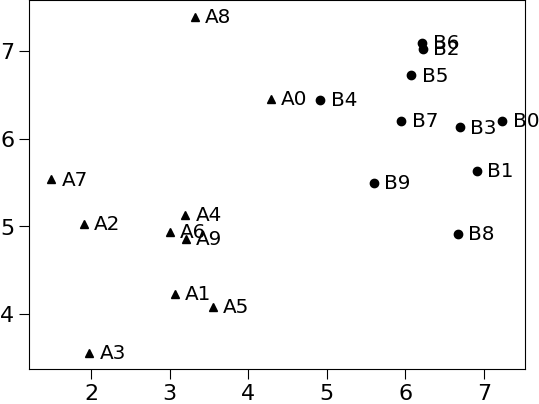

In [9]:
random.seed(1)
contrived_test(1, 2, True) 


Final result
 Cluster with centroid [6.10608987 6.03419771] contains:
  B0, B1, B2, B3, B4, B5, B6, B7, B8, B9
 Cluster with centroid [2.4050137  5.35225388] contains:
  A0, A1, A2, A3, A4, A5, A6, A7, A8, A9


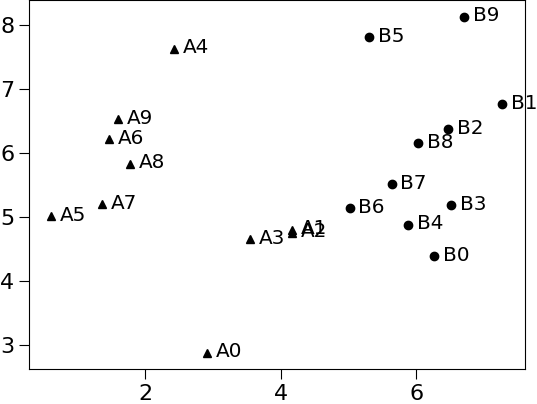

In [10]:
contrived_test(50, 2, False)

In [12]:
# # Figure 25-9 on page 574
def contrived_test2(num_trials, k, verbose = False):
    x_mean = 3
    x_sd = 1
    y_mean = 5
    y_sd = 1
    n = 8
    d1_samples = gen_distribution(x_mean,x_sd, y_mean, y_sd, n, 'A')
    plot_samples(d1_samples, 'k^')
    d2_samples = gen_distribution(x_mean+3,x_sd,y_mean, y_sd, n, 'B')
    plot_samples(d2_samples, 'ko')
    d3Samples = gen_distribution(x_mean, x_sd, y_mean+3, y_sd, n, 'C')
    plot_samples(d3Samples, 'kx')
    clusters = try_k_means(d1_samples + d2_samples + d3Samples,
                         k, num_trials, verbose)
    plt.ylim(0, 12)
    print('Final result has dissimilarity',
          round(dissimilarity(clusters), 3))
    for c in clusters:
        print('', c)

Final result has dissimilarity 90.128
 Cluster with centroid [5.5884966  4.43260236] contains:
  A0, A3, A5, B0, B1, B2, B3, B4, B5, B6, B7
 Cluster with centroid [2.80949911 7.11735738] contains:
  A1, A2, A4, A6, A7, C0, C1, C2, C3, C4, C5, C6, C7


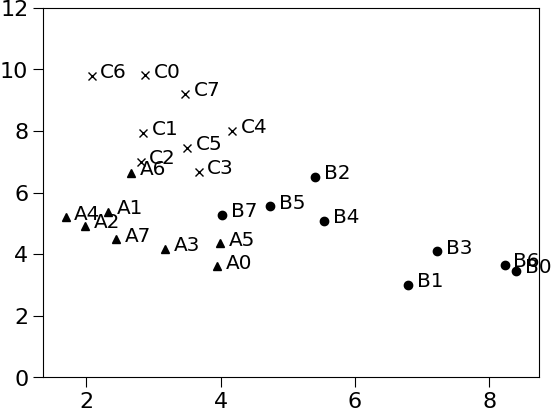

In [13]:
# Code on page 575
random.seed(0)
contrived_test2(40, 2)

Final result has dissimilarity 42.757
 Cluster with centroid [7.66239972 3.55222681] contains:
  B0, B1, B3, B6
 Cluster with centroid [3.56907939 4.95707576] contains:
  A0, A1, A2, A3, A4, A5, A7, B2, B4, B5, B7
 Cluster with centroid [3.12083099 8.06083681] contains:
  A6, C0, C1, C2, C3, C4, C5, C6, C7


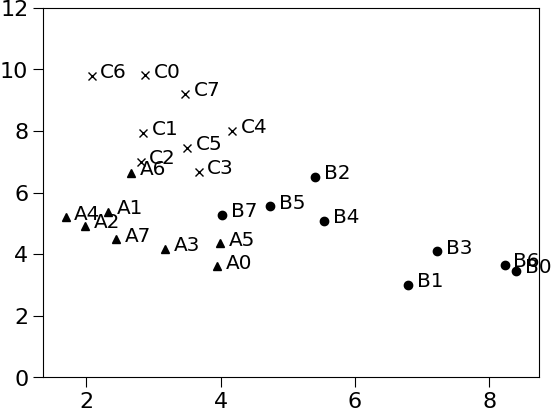

In [14]:
random.seed(0)
contrived_test2(40, 3)

Final result has dissimilarity 11.441
 Cluster with centroid [2.10900238 4.99452866] contains:
  A1, A2, A4, A7
 Cluster with centroid [4.92742554 5.60609442] contains:
  B2, B4, B5, B7
 Cluster with centroid [2.80974427 9.60386549] contains:
  C0, C6, C7
 Cluster with centroid [3.27637435 7.28932247] contains:
  A6, C1, C2, C3, C4, C5
 Cluster with centroid [3.70472053 4.04178035] contains:
  A0, A3, A5
 Cluster with centroid [7.66239972 3.55222681] contains:
  B0, B1, B3, B6


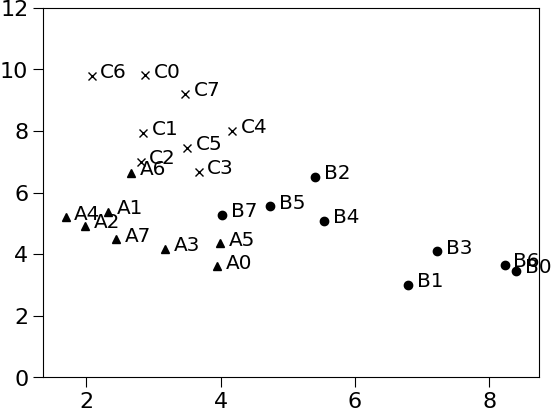

In [15]:
random.seed(0)
contrived_test2(40, 6)

In [16]:
# # Figure 25-12 on page 578
def read_mammal_data(fName, scale_method = None):
    """fName a CSV file describing dentition of mammals
       returns a dict mapping species to feature vectors
    """
    df = pd.read_csv('dentalFormulas.csv', comment = '#')
    df = df.set_index('Name')
    if scale_method != None:
        for c in df.columns:
            df[c] = scale_method(df[c])
    feature_vector_list = [np.array(df.loc[i].values)
                           for i in df.index]
    species_names = list(df.index)
    return {species_names[i]: feature_vector_list[i]
            for i in range(len(species_names))}

def build_mammal_examples(species_dict):
    examples = []
    for i in species_dict:
        example = Example(i, species_dict[i])
        examples.append(example)
    return examples

def test_teeth(file_name, num_clusters, num_trials,
               scale_method = None):
    def print_clustering(clustering):
        for c in clustering:
            names = ''
            for p in c.members():
                names += p.get_name() + ', '
            print('\n' + names[:-2]) #remove trailing comma and space
    species_dict = read_mammal_data(file_name, scale_method)
    examples = build_mammal_examples(species_dict)
    print_clustering(try_k_means(examples, num_clusters, num_trials))

In [17]:
# Code on page 579
random.seed(0)    
test_teeth('dentalFormulas.csv', 3, 40)


Bear, Cow, Deer, Elk, Fur seal, Grey seal, Lion, Sea lion

Badger, Cougar, Dog, Fox, Guinea pig, Human, Jaguar, Kangaroo, Mink, Mole, Mouse, Pig, Porcupine, Rabbit, Raccoon, Rat, Red bat, Skunk, Squirrel, Wolf, Woodchuck

Moose


In [18]:
# # Figure 25-13 on page 580
def z_scale(vals):
    """Assumes vals is a sequence of floats"""  
    result = np.array(vals) - np.array(vals).mean()
    return (result/np.std(result)).round(4)

def linear_scale(vals):
    """Assumes vals is a sequence of floats"""
    vals = np.array(vals)
    vals -= vals.min()
    return (vals/vals.max()).round(4)


In [19]:
random.seed(0)
test_teeth('dentalFormulas.txt', 3, 40, z_scale)


Badger, Bear, Cougar, Dog, Fox, Fur seal, Grey seal, Human, Jaguar, Lion, Mink, Mole, Pig, Raccoon, Red bat, Sea lion, Skunk, Wolf

Guinea pig, Kangaroo, Mouse, Porcupine, Rabbit, Rat, Squirrel, Woodchuck

Cow, Deer, Elk, Moose


In [20]:
# # Figure 25-15 on page 582
def add_labels(examples, label_file):
    df = pd.read_csv(label_file, comment = '#')
    df = df.set_index('Name')
    for e in examples:
        if e.get_name() in df.index:
            e.set_label(df.loc[e.get_name()]['Diet'])

def check_diet(cluster):
    herbivores, carnivores, omnivores = 0, 0, 0
    for m in cluster.members():
        if m.get_label() == 0:
            herbivores += 1
        elif m.get_label() == 1:
            carnivores += 1
        else:
            omnivores += 1
    print('  ', herbivores, 'herbivores,', carnivores, 'carnivores,',
          omnivores, 'omnivores\n')
    
def test_teeth_diet(features_file, labels_file, num_clusters,
                    num_trials, scale_method = None):
    def print_clustering(clustering):
        for c in clustering:
            names = ''
            for p in c.members():
                names += p.get_name() + ', '
            print(names[:-2])
            check_diet(c)
    species_dict = read_mammal_data(features_file, scale_method)
    examples = build_mammal_examples(species_dict)
    add_labels(examples, labels_file)
    print_clustering(try_k_means(examples, num_clusters, num_trials))

In [21]:
# Code on page 583
random.seed(0)
test_teeth_diet('dentalFormulas.csv', 'diet.csv', 3, 40, z_scale)

Badger, Bear, Cougar, Dog, Fox, Fur seal, Grey seal, Human, Jaguar, Lion, Mink, Mole, Pig, Raccoon, Red bat, Sea lion, Skunk, Wolf
   0 herbivores, 13 carnivores, 5 omnivores

Guinea pig, Kangaroo, Mouse, Porcupine, Rabbit, Rat, Squirrel, Woodchuck
   3 herbivores, 0 carnivores, 5 omnivores

Cow, Deer, Elk, Moose
   4 herbivores, 0 carnivores, 0 omnivores

